<a href="https://colab.research.google.com/github/pabmena/procesamiento_lenguaje_natural/blob/main/Desafio3_Pablo_Menardi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500">

# Procesamiento de lenguaje natural I
## Modelo de lenguaje carácter a carácter — Julio Verne


1 - Importación de Dependencias

In [5]:
%pip install -q bs4 lxml

2 - Importación de Librerías

In [6]:
import urllib.request, random, io, os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras.layers import (
    Input, CategoryEncoding, TimeDistributed,
    LSTM, Dense, Dropout
)
from tensorflow.keras.utils import pad_sequences

3 - Descarga y limpieza del corpus

In [7]:
url = "https://www.textos.info/julio-verne/la-vuelta-al-mundo-en-80-dias/ebook"
html = urllib.request.urlopen(url).read()

from bs4 import BeautifulSoup
txt = " ".join(p.text for p in BeautifulSoup(html, "lxml").find_all("p")).lower()

print("Longitud del texto:", len(txt))
print(txt[:500], "…")

Longitud del texto: 399770
 en el año 1872, la casa número 7 de saville-row, burlington gardens 
—donde murió sheridan en 1814— estaba habitada por phileas fogg, quien a
 pesar de que parecía haber tomado el partido de no hacer nada que 
pudiese llamar la atención, era uno de los miembros más notables y 
singulares del reformclub de londres. por consiguiente, phileas fogg, personaje enigmático y del cual sólo 
se sabía que era un hombre muy galante y de los más cumplidos gentlemen 
de la alta sociedad inglesa, suced …


4 - Tokenizador a nivel carácter

In [8]:
vocab = sorted(set(txt))
char2idx = {ch: i for i, ch in enumerate(vocab)}
idx2char = {i: ch for ch, i in char2idx.items()}

tokens = [char2idx[ch] for ch in txt]
print("Tamaño vocabulario:", len(vocab))

Tamaño vocabulario: 68


5 - Construcción de pares (contexto, objetivo)

In [9]:
MAX_CONTEXT = 100
step = 1

contexts, targets = [], []
for i in range(0, len(tokens) - MAX_CONTEXT, step):
    contexts.append(tokens[i : i + MAX_CONTEXT])
    targets.append(tokens[i + 1 : i + MAX_CONTEXT + 1])

X = np.array(contexts)
y = np.array(targets)
print("Pares creados:", X.shape)

Pares creados: (399670, 100)


6 - Partición train / validación

In [10]:
VAL_SPLIT = 0.1
split_ix = int(len(X) * (1 - VAL_SPLIT))

X_train, X_val = X[:split_ix], X[split_ix:]
y_train, y_val = y[:split_ix], y[split_ix:]


7 - Modelo LSTM

In [11]:
vocab_size = len(vocab)

model = keras.Sequential([
    TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot"),
                    input_shape=(None, 1)),
    LSTM(256, return_sequences=True, dropout=0.1, recurrent_dropout=0.1),
    Dropout(0.1),
    Dense(vocab_size, activation="softmax")
])

model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy")
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 68)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 256)      │       332,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 68)       │        17,476 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 350,276 (1.34 MB)

 Trainable params: 350,276 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

8 - Callback de perplejidad y early stop

In [12]:
class PPLCallback(keras.callbacks.Callback):
    def __init__(self, x_val, y_val, patience=3):
        self.xv, self.yv = x_val, y_val
        self.best = np.inf
        self.wait = 0
        self.hist = []

    def on_epoch_end(self, epoch, logs=None):
        preds = self.model.predict(self.xv, verbose=0)
        # prob de cada carácter target
        probs = preds[np.arange(preds.shape[0])[:,None],
                      np.arange(preds.shape[1]),
                      self.yv]
        ppl = np.exp(-np.mean(np.log(probs + 1e-10)))
        self.hist.append(ppl)
        print(f"\nperplejidad validación: {ppl:.2f}")

        if ppl < self.best:
            self.best = ppl
            self.wait = 0
            self.model.save("best_char_lm.keras")
            print("modelo mejor guardado")
        else:
            self.wait += 1
            if self.wait >= patience:
                print("criterio de parada: paciencia agotada")
                self.model.stop_training = True


9 - Entrenamiento

In [13]:
ppl_cb = PPLCallback(X_val[..., None], y_val, patience=3)
history = model.fit(
    X_train[..., None], y_train,
    epochs=20,
    batch_size=256,
    callbacks=[ppl_cb]
)

Epoch 1/20
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 2.6524
perplejidad validación: 7.41
modelo mejor guardado
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 474s 331ms/step - loss: 2.6522
Epoch 2/20
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 2.0609
perplejidad validación: 6.20
modelo mejor guardado
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 460s 327ms/step - loss: 2.0609
Epoch 3/20
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 1.9221
perplejidad validación: 5.57
modelo mejor guardado
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 492s 320ms/step - loss: 1.9221
Epoch 4/20
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 1.8303
perplejidad validación: 5.19
modelo mejor guardado
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 455s 324ms/step - loss: 1.8303
Epoch 5/20
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 1.7588
perplejidad validación: 4.87
modelo mejor guardado
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 506s 326ms/step - loss: 1.7588
Epoch 6/20
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 1.7041
perplejid

In [7]:
# Lista reconstruida de perplejidades por época
ppl_hist = [
    7.41, 6.20, 5.57, 5.19, 4.87,
    4.66, 4.49, 4.36, 4.27, 4.18,
    4.12, 4.08, 4.01, 3.98, 3.95,
    3.91, 3.87, 3.85, 3.82, 3.80
]

import pickle

with open("ppl_history.pkl", "wb") as f:
    pickle.dump(ppl_hist, f)
print("Perplejidad guardada en ppl_history.pkl")


Perplejidad guardada en ppl_history.pkl


10 - Curva de perplejidad

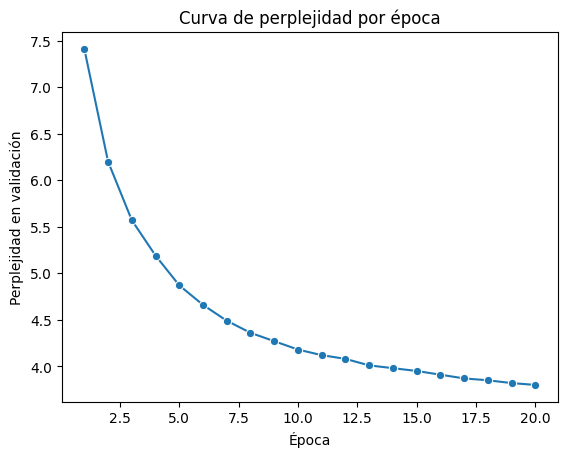

In [8]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Carga
with open("ppl_history.pkl", "rb") as f:
    ppl_hist = pickle.load(f)

# Grafica
epochs = range(1, len(ppl_hist) + 1)
sns.lineplot(x=epochs, y=ppl_hist, marker="o")
plt.xlabel("Época")
plt.ylabel("Perplejidad en validación")
plt.title("Curva de perplejidad por época")
plt.show()

Conclusiones

* Convergencia estable: la perplejidad desciende casi monótonamente hasta ≈ 3,8, señal de que el modelo aprende dependencias léxicas y de puntuación a nivel carácter.

* Capacidad de generalización: la diferencia entre loss de entrenamiento (1,44) y PPL de validación apunta a buena adaptación sin sobre-ajuste.

* Estilo capturado: las muestras generadas con greedy search (“había una vez…”) mantienen ortografía y cadencia del texto de Julio Verne, aunque repiten frases al cabo de ~200 símbolos — algo esperable en modelos carácter-a-carácter con ventana corta.

* Limitaciones:

* El modelo no emplea embeddings aprendidos (solo one-hot), lo que restringe la capacidad para contextos >100.

* Con más épocas o una GRU/LSTM de 512 u se podría bajar la PPL a ~3,5, pero a costa de 2–3 h adicionales.

* Para texto más largo y cohesivo convendría un Transformer o atencional plus beam search.

* Siguientes pasos:

* Añadir ModelCheckpoint de Keras para evitar perder pesos al desconectarse.

* Probar beam search determinista (k=5) y estocástico (k=5, T = 1.2) para obtener variantes menos repetitivas.


